In [1]:
import os
import glob
import mne
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy
from fooof import FOOOF, FOOOFGroup, fit_fooof_3d
from fooof.sim.gen import gen_aperiodic
import json

/tmp/ipykernel_35845/1207983033.py:8: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup, fit_fooof_3d


In [2]:
def compute_psds(age):
    subjects = [os.path.split(x)[-1] for x in glob.glob('/home/common/bonaiuto/devmobeta/data/sub-*')]
    subject_age_path = os.path.join('/home/common/bonaiuto/devmobeta/derivatives/')
    subject_age = os.path.join(subject_age_path, 'participants_v2.csv')

    sub_psds = []
    freqs = None
            
    with open(subject_age, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            print("Processing row:", row)
            subject = row['subject_id']
            session = row['session']
            subject_age = row['age']
            system = row['eeg_system']

            if system != "EGI":
                print(f"Skipping subject {subject} (EEG system: {system})")
                continue 
                            
            if subject_age == age:
                print(f"Processing subject {subject} with age {subject_age} (EGI)")
                sub_path = os.path.join('/home/common/bonaiuto/devmobeta/derivatives/', subject)
                ses_path = os.path.join(sub_path, session)
                print(ses_path)
                
                if os.path.exists(os.path.join(ses_path, 'eeg', 'NEARICA_NF')): 
                    print(f"Processing subject {subject} with age {subject_age} and session {session}")
                    eeg_path = os.path.join(ses_path, 'eeg', 'NEARICA_NF')
                    fname = os.path.join(eeg_path, f'03_ica_data/{subject}_task-devmobeta_grasp_eeg_ica_art_rej_interp_reref.set')

                    if os.path.exists(fname):
                        raw_data = mne.io.read_raw_eeglab(fname, preload=True)
                        srate = raw_data.info['sfreq']

                        # Prendre tous les canaux EEG disponibles
                        all_chan_idx = np.arange(len(raw_data.info['ch_names']))
                        n_chans = len(all_chan_idx)

                        # Extraire les données des canaux EEG
                        #data = raw_data.get_data()[all_chan_idx, :]
                        #n_chans, n_samps = data.shape

                        if freqs is None: 
                            sample_chan_data = raw_data.get_data()[0:1, :]
                            winsize = srate 
                            overlap = int(winsize / 2)
                            temp_freqs, _ = scipy.signal.welch(
                                sample_chan_data,  
                                fs=srate,  
                                window='hann',  
                                nperseg=winsize,  
                                noverlap=overlap,  
                                nfft=int(winsize * 20), 
                                detrend='constant', 
                                return_onesided=True,  
                                scaling='density',  
                                axis=-1
                            )
                            f_idx = (temp_freqs <= 40)
                            freqs = temp_freqs[f_idx]
                            
                        # Initialiser le tableau pour stocker les PSD de tous les canaux
                        subject_psd = np.zeros((n_chans, len(freqs)))
                        
                        for i, chan_idx in enumerate(all_chan_idx):
                            # Extraire les données pour ce canal
                            chan_data = raw_data.get_data()[chan_idx:chan_idx+1, :]
                            
                            # Utiliser une fenêtre de 1s avec un chevauchement de 50% 
                            winsize = srate 
                            overlap = int(winsize / 2)     
 
                            # Calcul de la PSD pour ce canal
                            _, chan_psd = scipy.signal.welch( 
                                chan_data,  
                                fs=srate,  
                                window='hann',  
                                nperseg=winsize,  
                                noverlap=overlap,  
                                nfft=int(winsize * 20), 
                                detrend='constant', 
                                return_onesided=True,  
                                scaling='density',  
                                axis=-1
                            ) 
 
                            # Filtrage des fréquences jusqu'à 40 Hz 
                            f_idx = (temp_freqs <= 40) 
                            subject_psd[i, :] = chan_psd[0, f_idx]  # [0] pour retirer la dimension supplémentaire
                        
                        # Ajouter les PSD de ce sujet à la liste
                        sub_psds.append(subject_psd)
                    else: 
                        print(f"Processing subject {subject} with age {subject_age} and session {session} doesn't exist")
    
        sub_psds = np.array(sub_psds)    
        return freqs, sub_psds


In [3]:
freqs, sub_three_psds=compute_psds('three')
freqs, sub_six_psds=compute_psds('six')
freqs, sub_twelve_psds=compute_psds('twelve')

Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-201 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-201/ses-01
Processing subject sub-201 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-201 (EEG system: )
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-201 (EEG system: )
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-201 (EEG system: )
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-06', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-202', 'orig_participant_id': 'RA', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-203', 'orig

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-204 (EEG system: )
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-205 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-205/ses-01
Processi

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-205 (EEG system: )
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-206 (EEG system: )
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-206 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-206/ses-02
Processing subject sub-206 with age three and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-206 (EEG system: )
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-207 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-207/ses-02
Processing subject sub-207 with age three and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-208 (EEG system: )
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-208 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-02
Processing subject sub-208 with age three and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-209 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-01
Processing subject sub-209 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-210 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-01
Processing subject sub-210 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-210 (EEG system: )
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-210 (EEG system: )
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-211 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-211/ses-01
Processing subject sub-211 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-211 (EEG system: )
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-212 (EEG system: )
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-212 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-212/ses-02
Processing subject sub-212 with age three and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-213 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-01
Processing subject sub-213 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-213 (EEG system: )
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-213 (EEG system: )
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-213 (EEG system: )
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-214 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-214/ses-01
Processing subject sub-214 with age three and session ses-01
Processing subject 

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-215 (EEG system: )
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-216 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-216/ses-01
Processing subject sub-216 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-216 (EEG system: )
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-217 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-217/ses-01
Processing subject sub-217 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-217 (EEG system: )
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'ABL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-218 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-218/ses-01
Processing subject sub-218 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'ABL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'AB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-219 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-219/ses-01
Processing subject sub-219 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-220 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-220/ses-01
Processing subject sub-220 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-221 (EEG system: )
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-221 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-02
Processing subject sub-221 with age three and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-221 (EEG system: )
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-221 (EEG system: )
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-222 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-222/ses-01
Processing subject sub-222 with age three and session ses-01
Processing subject sub-222 with age three and session ses-01 doesn't exist
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'e

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-223 (EEG system: )
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-224 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-224/ses-02
Processing subject sub-224 with age three and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-224 (EEG system: )
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-225 (EEG system: )
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-225 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-225/ses-02
Processing subject sub-225 with age three and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-225 (EEG system: )
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-226 (EEG system: )
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-226 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-226/ses-02
Processing subject sub-226 with age three and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-226 (EEG system: )
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-226 (EEG system: )
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-227 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-227/ses-01
Processing subject sub-227 with age three and session ses-01
Processing subject sub-227 with age three and session ses-01 doesn't exist
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', '

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-229', 'orig_participant_id': 'AE', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-229 (EEG system: )
Processing row: {'subject_id': 'sub-229', 'orig_participant_id': 'AE', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-229 (EEG system: )
Processing row: {'subject_id': 'sub-230', 'orig_participant_id': 'IM', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-230 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-230/ses-01
Processing subject sub-230 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-230', 'orig_participant_id': 'IM', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-231 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-231/ses-01
Processing subject sub-231 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-231 (EEG system: )
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-231 (EEG system: )
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-232 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-232/ses-01
Processing subject sub-232 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-232 (EEG system: )
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-233 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-233/ses-01
Processing subject sub-233 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-233 (EEG system: )
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-234 (EEG system: )
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-234 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-234/ses-02
Processing subject sub-234 with age three and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-234 (EEG system: )
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-234 (EEG system: )
Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-235 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-235/ses-01
Processing subject sub-235 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-235 (EEG system: )
Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-235 (EEG system: )
Processing row: {'subject_id': 'sub-236', 'orig_participant_id': 'ES', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-236 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-236/ses-01
Processing subject sub-236 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-236', 'orig_participant_id': 'ES', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-236 (EEG system: )
Processing row: {'subject_id': 'sub-236', 'orig_participant_id': 'ES', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-236 (EEG system: )
Processing row: {'subject_id': 'sub-237', 'orig_participant_id': 'LMP', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-237 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-237/ses-01
Processing subject sub-237 with age three and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-238', 'orig_participant_id': 'LM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-238 (EEG system: )
Processing row: {'subject_id': 'sub-238', 'orig_participant_id': 'LM', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-238 with age three (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-238/ses-02
Processing subject sub-238 with age three and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-238', 'orig_participant_id': 'LM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-238 (EEG system: )
Processing row: {'subject_id': 'sub-238', 'orig_participant_id': 'LM', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Skipping subject sub-238 (EEG system: BrainVision)
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-239 (EEG system: )
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-239 (EEG system: )
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_sy

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-241 (EEG system: )
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-241 (EEG system: )
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-241 (EEG system: )
Processing row: {'subject_id': 'sub-242', 'orig_participant_id': 'LM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-242 (EEG system: )
Processing row: {'subject_id': 'sub-242', 'orig_participant_id': 'LM', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-242 (EEG system: )
Processing row: {'subject_id': 'sub-242', 'orig_participant_id': 'LM', 'session': 'ses-03', 'age': 'twelve', 'sex':

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-201 (EEG system: )
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-06', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-202', 'orig_participant_id': 'RA', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-202 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-202/ses-02
Processing subject sub-202 with age six and session ses-02
Processing subject sub-202 with age six and session ses-02 doesn't exist
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-204 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-204/ses-01
Processing subject sub-204 with age six and session ses-01


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-204 (EEG system: )
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-205 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-205/ses-02
Processing subject sub-205 with age six and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-205 (EEG system: )
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-206 (EEG system: )
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-206 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-206/ses-04
Processing subject sub-206 with age six and session ses-04


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-206 (EEG system: )
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-207 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-207/ses-04
Processing subject sub-207 with age six and session ses-04


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-208 (EEG system: )
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-208 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-03
Processing subject sub-208 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-209 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-03
Processing subject sub-209 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-210 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-03
Processing subject sub-210 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-210 (EEG system: )
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-210 (EEG system: )
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-211 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-211/ses-03
Processing subject sub-211 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-211 (EEG system: )
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-212 (EEG system: )
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-212 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-212/ses-03
Processing subject sub-212 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-213 (EEG system: )
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-213 (EEG system: )
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-213 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-04
Processing subject sub-213 with age six and session ses-04


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-213 (EEG system: )
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-214 (EEG system: )
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-214 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-214/ses-03
Processing subject sub-214 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-214 (EEG system: )
Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-215 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-215/ses-03
Processing subject sub-215 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-215 (EEG system: )
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-216 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-216/ses-03
Processing subject sub-216 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-216 (EEG system: )
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-217 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-217/ses-03
Processing subject sub-217 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-217 (EEG system: )
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'ABL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'ABL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-218 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-218/ses-02
Processing subject sub-218 with age six and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'AB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-219 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-219/ses-02
Processing subject sub-219 with age six and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-220 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-220/ses-03
Processing subject sub-220 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-221 (EEG system: )
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-221 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-03
Processing subject sub-221 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-221 (EEG system: )
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-221 (EEG system: )
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-222 (EEG system: )
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-222 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-222/ses-03
Processing subject sub-222 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-222 (EEG system: )
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-223 (EEG system: )
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-223 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-223/ses-04
Processing subject sub-223 with age six and session ses-04


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-223 (EEG system: )
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-224 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-224/ses-03
Processing subject sub-224 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-224 (EEG system: )
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-225 (EEG system: )
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-225 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-225/ses-03
Processing subject sub-225 with age six and session ses-03


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-225 (EEG system: )
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-226 (EEG system: )
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-226 (EEG system: )
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-226 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-226/ses-04
Processing subject sub-226 with age six and session ses-04


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-226 (EEG system: )
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-227 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-227/ses-02
Processing subject sub-227 with age six and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-227 (EEG system: )
Processing row: {'subject_id': 'sub-228', 'orig_participant_id': 'AFW', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-228 (EEG system: )
Processing row: {'subject_id': 'sub-228', 'orig_participant_id': 'AFW', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-228', 'orig_participant_id': 'AFW', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-228 (EEG system: )
Processing row: {'subject_id': 'sub-229', 'orig_participant_id': 'AE', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-229 (EEG system: )
Processing row: {'subject_id': 'sub-229', 'orig_participant_id': 'AE', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
P

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-231 (EEG system: )
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-231 (EEG system: )
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-232 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-232/ses-04
Processing subject sub-232 with age six and session ses-04


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-232 (EEG system: )
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-233 (EEG system: )
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-233 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-233/ses-04
Processing subject sub-233 with age six and session ses-04


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-234 (EEG system: )
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-234 (EEG system: )
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-234 (EEG system: )
Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-235 (EEG system: )
Processin

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-239 (EEG system: )
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-240 (EEG system: )
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-240 with age six (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-240/ses-02
Processing subject sub-240 with age six and session ses-02


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-240 (EEG system: )
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-241 (EEG system: )
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-241 (EEG system: )
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-241 (EEG system: )
Processing row: {'subject_id': 'sub-242', 'orig_participant_id': 'LM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping s

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-202', 'orig_participant_id': 'RA', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-203 with age twelve (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-203/ses-05
Processing subject sub-203 with age twelve and session ses-05


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-204 (EEG system: )
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-204 with age twelve (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-204/ses-04
Processing subject sub-204 with age twelve and session ses-04


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-205 (EEG system: )
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-206 (EEG system: )
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': '

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-208 (EEG system: )
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Processing subject sub-208 with age twelve (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-05
Processing subject sub-208 with age twelve and session ses-05


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Processing subject sub-209 with age twelve (EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-05
Processing subject sub-209 with age twelve and session ses-05


/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-210 (EEG system: )
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-210 (EEG system: )
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'ses

/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_35845/2203082660.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-221 (EEG system: )
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'F', '

In [4]:
print(f'N 3m: {sub_three_psds.shape[0]}')
print(f'N 6m: {sub_six_psds.shape[0]}')
print(f'N 12m: {sub_twelve_psds.shape[0]}')

N 3m: 33
N 6m: 31
N 12m: 7


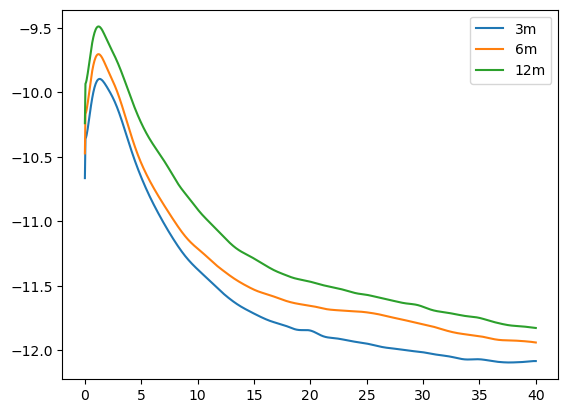

In [5]:
plt.plot(freqs,np.log10(np.mean(np.mean(sub_three_psds,axis=1),axis=0)),label='3m')
plt.plot(freqs,np.log10(np.mean(np.mean(sub_six_psds,axis=1),axis=0)),label='6m')
plt.plot(freqs,np.log10(np.mean(np.mean(sub_twelve_psds,axis=1),axis=0)),label='12m')
plt.legend()

In [6]:
def parameterize_psds(freqs, sub_psds):
    n_chans=sub_psds.shape[1]
    fg = FOOOFGroup()
    fgs=fit_fooof_3d(fg, freqs, sub_psds, [.05, 40])
    
    sub_periodic=np.zeros(sub_psds.shape)
    sub_aperiodic=np.zeros(sub_psds.shape)
    for s_idx, fg in enumerate(fgs):
        for chan in range(n_chans):
            if chan in fg.null_inds_:
                sub_aperiodic[s_idx,chan,:]=float('NaN')
                sub_periodic[s_idx,chan,:]=float('NaN')
            else:
                fm = fg.get_fooof(ind=chan, regenerate=True)
                ap_params=fm.get_params('aperiodic_params')
                sub_aperiodic[s_idx,chan,:] = gen_aperiodic(freqs, ap_params)
                sub_periodic[s_idx,chan,:]=np.log10(sub_psds[s_idx,chan,:])-sub_aperiodic[s_idx,chan,:]
                print(sub_periodic.shape)
    return fgs, sub_periodic, sub_aperiodic

In [7]:
fgs_3m, sub_three_periodic, sub_three_aperiodic=parameterize_psds(freqs, sub_three_psds)
fgs_6m, sub_six_periodic, sub_six_aperiodic=parameterize_psds(freqs, sub_six_psds)
fgs_12m, sub_twelve_periodic, sub_twelve_aperiodic=parameterize_psds(freqs, sub_twelve_psds)

Running FOOOFGroup across 4257 power spectra.


/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 

/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in power
  ys = offset - np.log10(xs**exp)


(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 801)
(33, 129, 

/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)
/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in power
  ys = offset - np.log10(xs**exp)


(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 801)
(31, 129, 

/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 129, 801)
(7, 12

/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


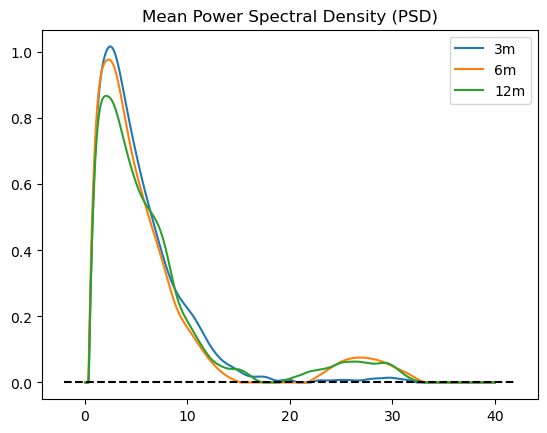

In [10]:
mean_psd_3m=np.mean(np.mean(sub_three_periodic,axis=1),axis=0)
mean_psd_3m[mean_psd_3m<0]=0
mean_psd_6m=np.mean(np.mean(sub_six_periodic,axis=1),axis=0)
mean_psd_6m[mean_psd_6m<0]=0
mean_psd_12m=np.mean(np.mean(sub_twelve_periodic,axis=1),axis=0)
mean_psd_12m[mean_psd_12m<0]=0

plt.plot(freqs,mean_psd_3m,label='3m')
plt.plot(freqs,mean_psd_6m,label='6m')
plt.plot(freqs,mean_psd_12m,label='12m')
plt.plot(plt.xlim(), [0, 0],'k--')
plt.title('Mean Power Spectral Density (PSD)')
plt.legend()

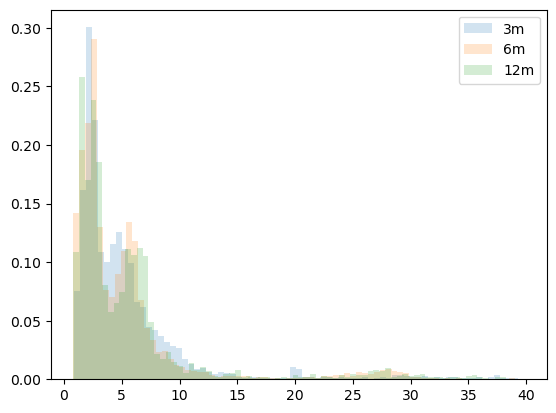

In [12]:
all_peaks_3m = []
all_peaks_6m = []
all_peaks_12m = []

# 3 m
for s_idx, fg in enumerate(fgs_3m):
    for chan in range(len(fg.power_spectra)):  # Assure que chan est dans les limites
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks = fm.get_params('peak_params', 'CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_3m.extend(peaks.tolist())  
        else:
            all_peaks_3m.append(peaks)

# 6 m
for s_idx, fg in enumerate(fgs_6m):
    for chan in range(len(fg.power_spectra)):
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks = fm.get_params('peak_params', 'CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_6m.extend(peaks.tolist())
        else:
            all_peaks_6m.append(peaks)

# 12 m
for s_idx, fg in enumerate(fgs_12m):
    for chan in range(len(fg.power_spectra)):
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks = fm.get_params('peak_params', 'CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_12m.extend(peaks.tolist())
        else:
            all_peaks_12m.append(peaks)

# Affichage des histogrammes
plt.hist(all_peaks_3m, 75, alpha=.2, density=True, label='3m')
plt.hist(all_peaks_6m, 75, alpha=.2, density=True, label='6m')
plt.hist(all_peaks_12m, 75, alpha=.2, density=True, label='12m')
plt.legend()
plt.show()


In [48]:
def define_fois(freqs, mean_psd, age, debug=False):
    mean_resid=mean_psd
    foi_pk_freqs=[]
    foi_pk_vals=[]    
    foi_fwhms=[]
    foi_ranges=[]
    foi_info = {} 
    foi_counter = 1  
    
    orig_pks,properties=scipy.signal.find_peaks(mean_resid)
    while True:
        pks,properties=scipy.signal.find_peaks(mean_resid)

        pk_vals=mean_resid[pks]
        sorted_idx=np.argsort(-pk_vals)
        pk_vals=pk_vals[sorted_idx]
        pks=pks[sorted_idx]

        if len(pks)==0:
            break
        pk_idx=pks[0]
        pk_val=pk_vals[0]
        pk_freq=freqs[pk_idx]
        
        if pk_val<np.std(mean_resid):
            if debug:
                print('Peak val={}, thresh={}'.format(pk_val,.5*np.std(mean_resid)))
            break
        
        l_idx=np.where(mean_resid[:pk_idx]<=pk_val*.5)[0]
        r_idx=np.where(mean_resid[pk_idx:]<=pk_val*.5)[0]

        if len(l_idx) and len(r_idx):
            l_freq=freqs[l_idx[-1]]
            r_freq=freqs[pk_idx+r_idx[0]]
            r_side=(r_freq-pk_freq)
            l_side=(pk_freq-l_freq)
            fwhm=2*np.min([r_side, l_side])
        elif len(l_idx):
            l_freq=freqs[l_idx[-1]]
            fwhm=2*(pk_freq-l_freq)
        elif len(r_idx):
            r_freq=freqs[pk_idx+r_idx[0]+1]
            fwhm=2*(r_freq-pk_freq)

        l_freq=pk_freq-fwhm*.5
        r_freq=pk_freq+fwhm*.5
        sd=fwhm/(2*np.sqrt(2*np.log(2)))
        A=pk_vals[0]*np.exp(-.5*((freqs-pk_freq)/sd)**2)
        nearest_orig=np.min(np.abs(freqs[np.array(orig_pks)]-pk_freq))

        if pk_val>np.nanstd(mean_resid) and ((pk_freq<10 and fwhm>2) or (pk_freq>=10 and fwhm>2.4) and nearest_orig<3):
            print('Peak: freq={}, val={}, width={}, range={}-{}'.format(pk_freq, pk_val, fwhm, pk_freq-fwhm*.5, pk_freq+fwhm*.5))
            print('Distance to nearest original peak={}'.format(nearest_orig))
            if debug:
                plt.figure(figsize=(12,4))
                plt.subplot(1,2,1)
                plt.plot(freqs,mean_resid)
                plt.plot(freqs[pks],mean_resid[pks],'ro')
                plt.subplot(1,2,2)
                plt.plot(freqs,mean_resid)
                plt.plot(freqs,A)
            
            foi_pk_freqs.append(pk_freq)
            foi_pk_vals.append(pk_val)
            foi_fwhms.append(fwhm)
            foi_ranges.append([l_freq,r_freq])
    
            band_name = f'FOI_{foi_counter}'
            foi_info[band_name] = {'frequency_range': [l_freq, r_freq], 'peak_frequency': pk_freq}
            foi_counter += 1
            
        elif debug:
            if not ((pk_freq<10 and fwhm>2) or (pk_freq>=10 and fwhm>2.4)):
                print('Peak: freq={}, fhwm={} to narrow'.format(pk_freq, fwhm))
            if pk_val<=np.std(mean_resid):
                print('Peak: freq={} too low amplitude'.format(pk_freq))
            if nearest_orig>=3:
                print('Peak: freq={} too far from original peaks'.format(pk_freq))

        mean_resid=mean_resid-A
        mean_resid[mean_resid<0]=0
    sorted_idx=np.argsort(foi_pk_freqs)
    
    foi_pk_freqs=np.array(foi_pk_freqs)
    foi_pk_vals=np.array(foi_pk_vals)
    foi_fwhms=np.array(foi_fwhms)
    foi_ranges=np.array(foi_ranges)
    
    foi_pk_freqs=foi_pk_freqs[sorted_idx]
    foi_pk_vals=foi_pk_vals[sorted_idx]
    foi_fwhms=foi_fwhms[sorted_idx]
    foi_ranges=foi_ranges[sorted_idx,:]

    with open(f'frequency_ranges_{age}_EGI_all-channels.json', 'w') as json_file:
        json.dump(foi_info, json_file)
    
    plt.figure()
    plt.plot(freqs,mean_psd, label='Mean PSD')
    for f_idx in range(foi_ranges.shape[0]):
        sd=foi_fwhms[f_idx]/(2*np.sqrt(2*np.log(2)))
        A=foi_pk_vals[f_idx]*np.exp(-.5*((freqs-foi_pk_freqs[f_idx])/sd)**2)
        plt.plot(freqs,A)
        plt.title(f'Peak Detection for {age} months')
    
    return foi_info, foi_pk_freqs,foi_pk_vals,foi_fwhms,foi_ranges

Peak: freq=2.5, val=1.017180995066486, width=3.5, range=0.75-4.25
Distance to nearest original peak=0.0
Peak: freq=5.8500000000000005, val=0.5010362902732824, width=3.6000000000000014, range=4.05-7.650000000000001
Distance to nearest original peak=3.3500000000000005
Peak: freq=9.55, val=0.2166841937704515, width=4.200000000000001, range=7.45-11.650000000000002
Distance to nearest original peak=7.050000000000001
Peak: freq=1.25, fhwm=0.7 to narrow
Peak: freq=13.15 too far from original peaks
Peak: freq=1.7000000000000002, fhwm=0.5 to narrow
Peak: freq=17.45, fhwm=1.9000000000000057 to narrow
Peak: freq=29.700000000000003, val=0.01454202190592213, width=3.6999999999999957, range=27.850000000000005-31.55
Distance to nearest original peak=0.0
Peak: freq=4.7, fhwm=0.8000000000000007 to narrow
Peak: freq=8.15, fhwm=0.9000000000000004 to narrow
Peak: freq=8.15 too far from original peaks
Peak: freq=19.8, fhwm=1.3000000000000043 to narrow
Peak: freq=25.1, val=0.00760197719514971, width=3.10000

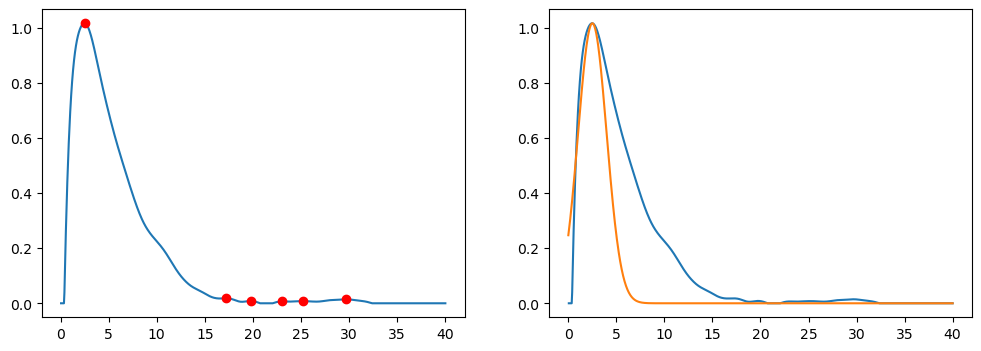

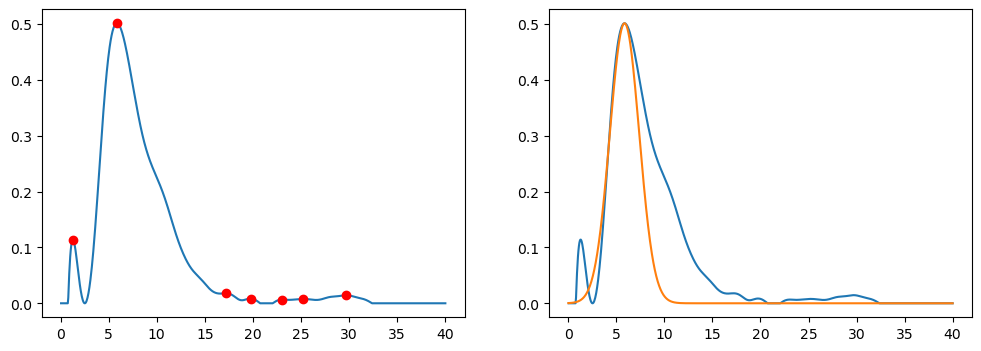

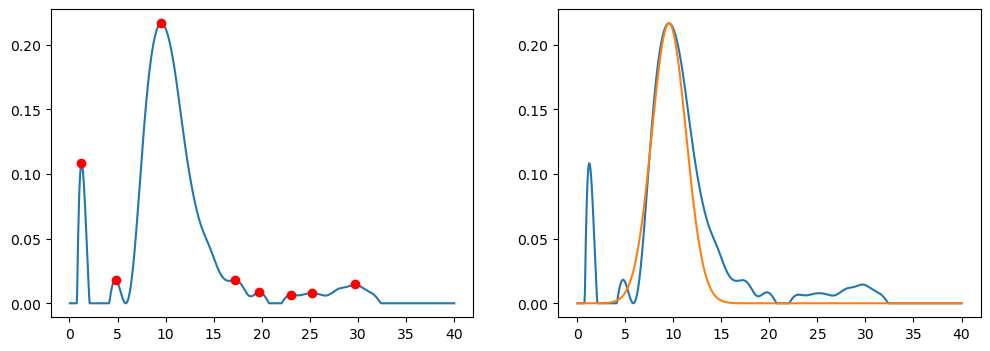

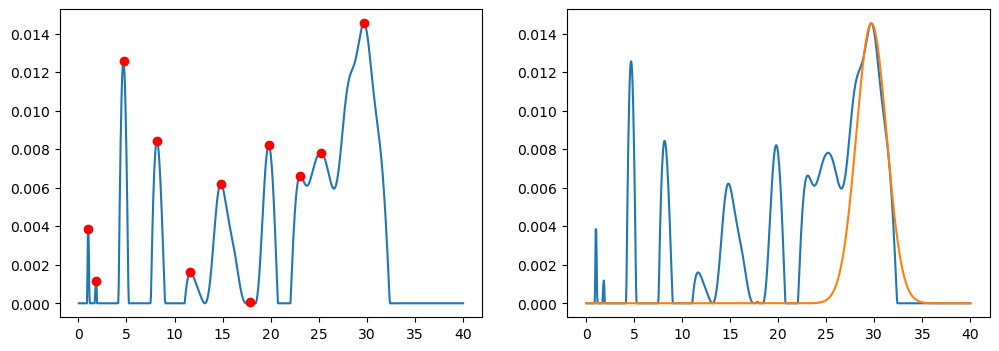

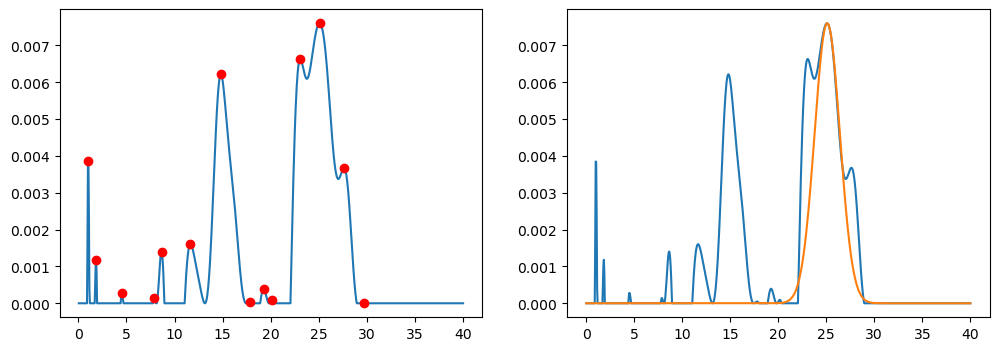

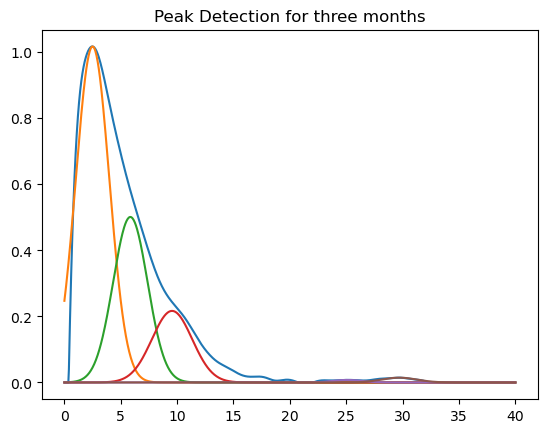

In [49]:
foi_info_3m, foi_pk_freqs_3m,foi_pk_vals_3m,foi_fwhms_3m,foi_ranges_3m=define_fois(freqs, mean_psd_3m, 'three', debug=True)

Peak: freq=2.3000000000000003, val=0.977658610431793, width=3.3000000000000007, range=0.6499999999999999-3.9500000000000006
Distance to nearest original peak=0.0
Peak: freq=5.550000000000001, val=0.5087318072950853, width=3.700000000000001, range=3.7-7.400000000000001
Distance to nearest original peak=3.2500000000000004
Peak: freq=8.6, val=0.1791741774301395, width=3.1999999999999993, range=7.0-10.2
Distance to nearest original peak=6.299999999999999
Peak: freq=1.2000000000000002, fhwm=0.7000000000000002 to narrow
Peak: freq=11.100000000000001 too far from original peaks
Peak: freq=26.900000000000002, val=0.07563916419113853, width=6.5, range=23.650000000000002-30.150000000000002
Distance to nearest original peak=0.0
Peak: freq=13.15, fhwm=2.099999999999998 to narrow
Peak: freq=13.15 too far from original peaks
Peak: freq=4.4, fhwm=0.8000000000000007 to narrow
Peak: freq=1.6, fhwm=0.2999999999999998 to narrow
Peak: freq=30.85, fhwm=2.200000000000003 to narrow
Peak: freq=30.85 too far f

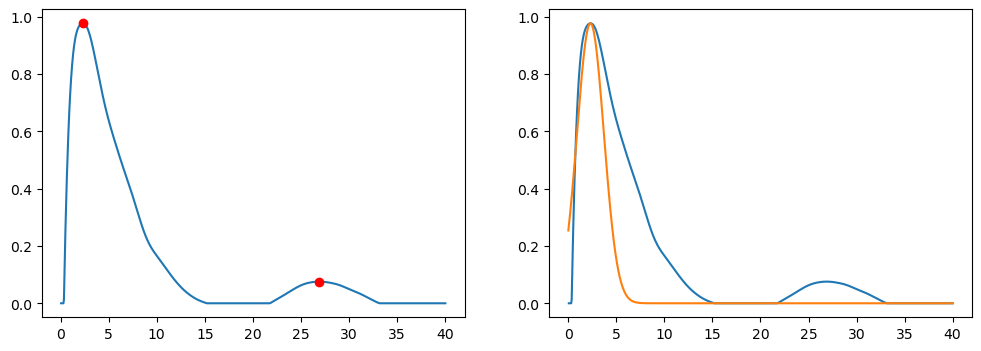

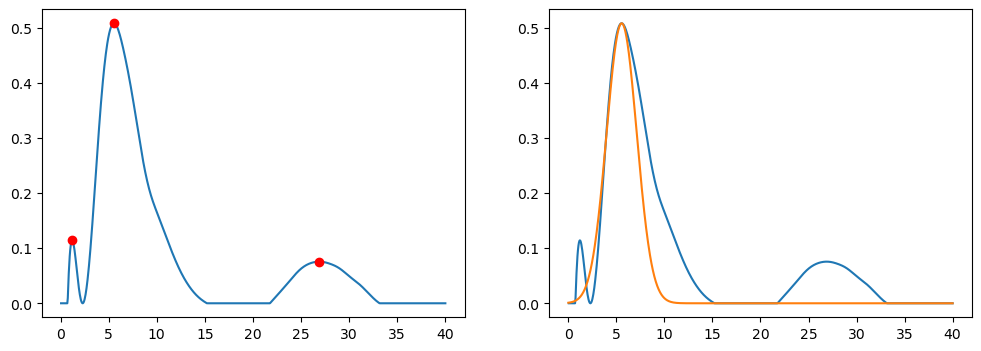

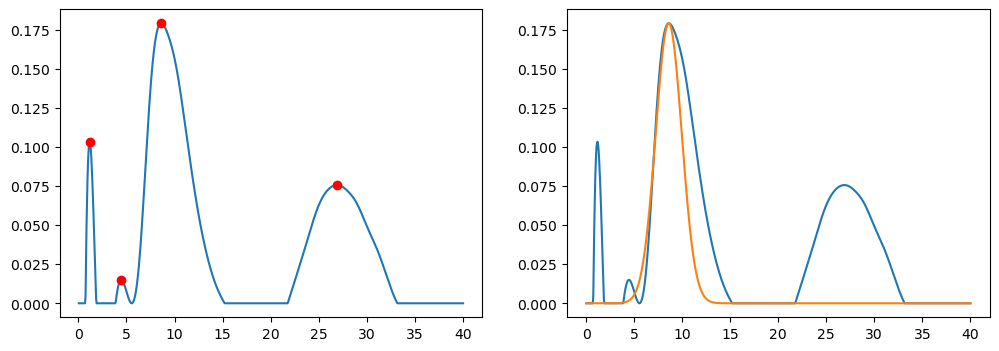

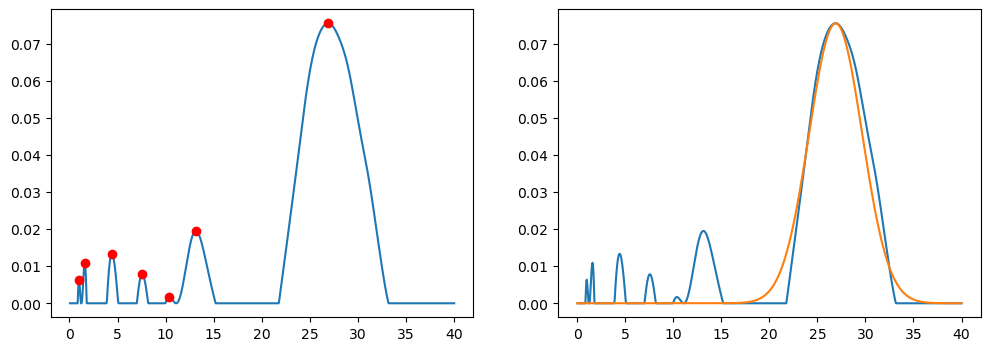

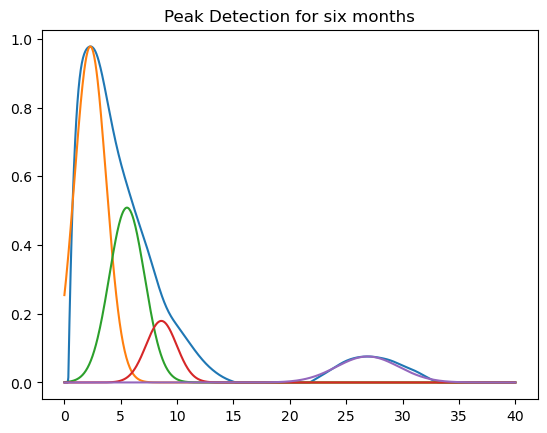

In [50]:
foi_info_6m, foi_pk_freqs_6m,foi_pk_vals_6m,foi_fwhms_6m,foi_ranges_6m=define_fois(freqs, mean_psd_6m, 'six', debug=True)

Peak: freq=2.1, val=0.8678007337637023, width=2.9000000000000004, range=0.6499999999999999-3.5500000000000003
Distance to nearest original peak=0.0
Peak: freq=5.15, val=0.5507624524807325, width=3.6000000000000005, range=3.35-6.950000000000001
Distance to nearest original peak=3.0500000000000003
Peak: freq=7.9, val=0.2934843759011359, width=2.8000000000000007, range=6.5-9.3
Distance to nearest original peak=5.800000000000001
Peak: freq=10.5 too far from original peaks
Peak: freq=1.1500000000000001, fhwm=0.6000000000000001 to narrow
Peak: freq=26.35, val=0.06325094939212267, width=9.100000000000001, range=21.8-30.900000000000002
Distance to nearest original peak=0.0
Peak: freq=13.0, val=0.0461394328321188, width=2.799999999999997, range=11.600000000000001-14.399999999999999
Distance to nearest original peak=1.5500000000000007
Peak: freq=4.0, fhwm=0.8999999999999995 to narrow
Peak: freq=15.25, fhwm=2.0 to narrow
Peak: freq=29.6, fhwm=1.6000000000000014 to narrow
Peak: freq=0.950000000000

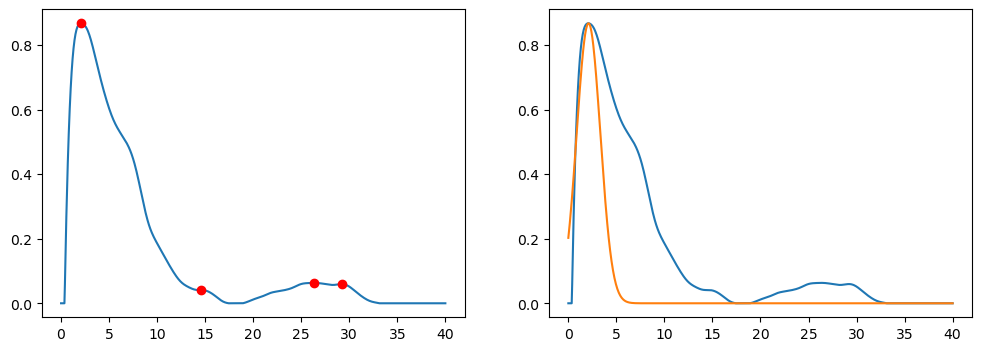

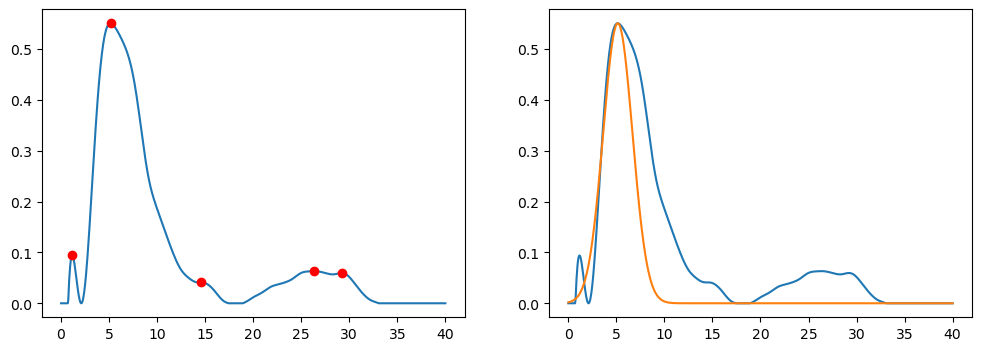

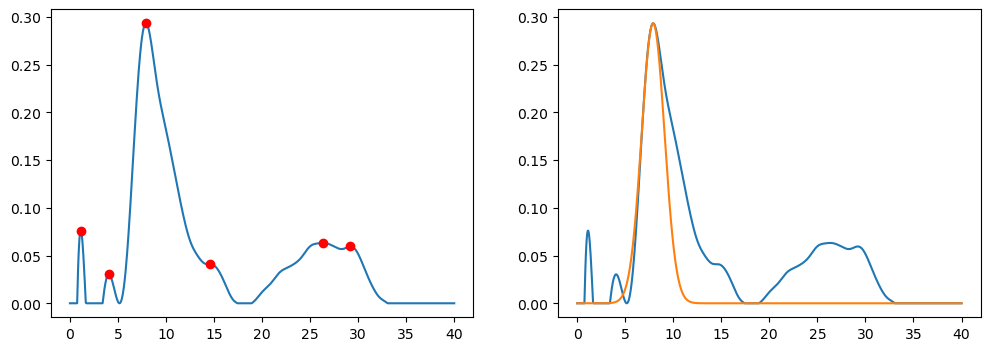

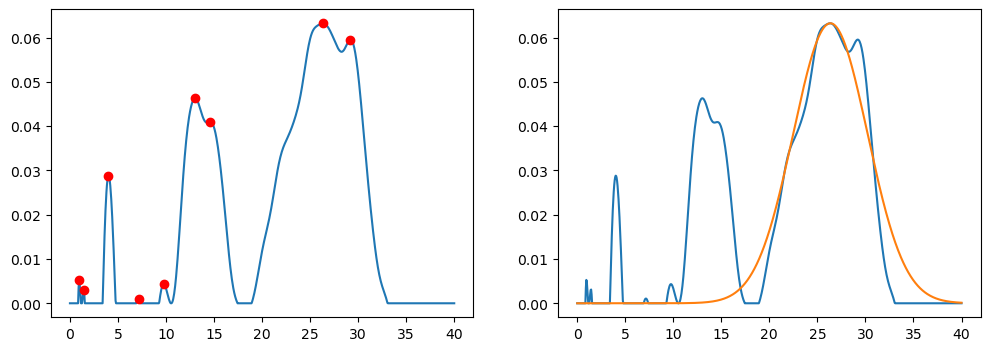

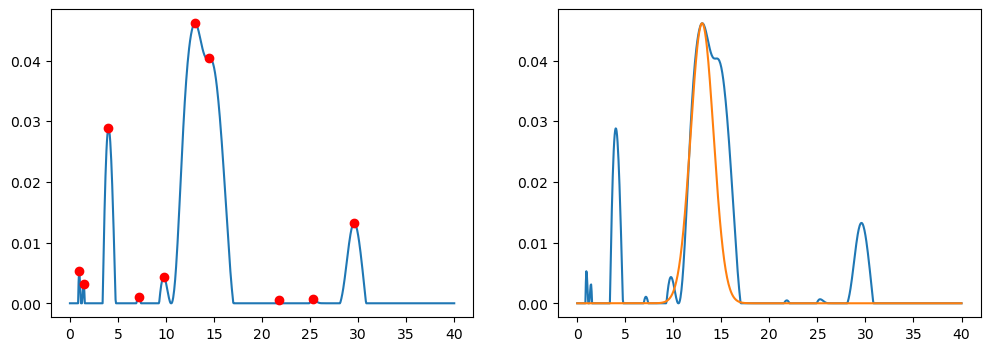

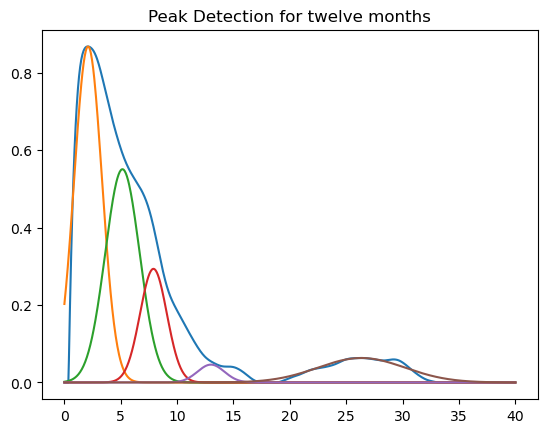

In [51]:
foi_info_12m,foi_pk_freqs_12m,foi_pk_vals_12m,foi_fwhms_12m,foi_ranges_12m=define_fois(freqs, mean_psd_12m, 'twelve', debug=True)

In [40]:
import scipy.io

fname = "processed_psd_three.mat"
output_path = fname  

scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'psd': sub_three_psds,
                     'periodic': sub_three_periodic,
                     'aperiodic': sub_three_aperiodic,
                     'foi_pk_freqs': foi_pk_freqs_3m,
                     'foi_pk_vals': foi_pk_vals_3m,
                     'foi_fwhms': foi_fwhms_3m,
                     'foi_ranges': foi_ranges_3m
                 })  

In [41]:
import scipy.io

fname = "processed_psd_six.mat"
output_path = fname  

scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'psd': sub_six_psds,
                     'periodic': sub_six_periodic,
                     'aperiodic': sub_six_aperiodic,
                     'foi_pk_freqs': foi_pk_freqs_6m,
                     'foi_pk_vals': foi_pk_vals_6m,
                     'foi_fwhms': foi_fwhms_6m,
                     'foi_ranges': foi_ranges_6m
                 })  

In [42]:
import scipy.io

fname = "processed_psd_twelve.mat"
output_path = fname  

scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'psd': sub_twelve_psds,
                     'periodic': sub_twelve_periodic,
                     'aperiodic': sub_twelve_aperiodic,
                     'foi_pk_freqs': foi_pk_freqs_12m,
                     'foi_pk_vals': foi_pk_vals_12m,
                     'foi_fwhms': foi_fwhms_12m,
                     'foi_ranges': foi_ranges_12m
                 })  

In [43]:
foi_ranges_3m

array([[ 0.75,  4.25],
       [ 4.05,  7.65],
       [ 7.45, 11.65],
       [11.05, 15.25],
       [23.55, 26.65],
       [27.85, 31.55]])

In [44]:
foi_ranges_6m

array([[ 0.65,  3.95],
       [ 3.7 ,  7.4 ],
       [ 7.  , 10.2 ],
       [ 9.75, 12.45],
       [23.65, 30.15]])

In [45]:
foi_ranges_12m

array([[ 0.65,  3.55],
       [ 3.35,  6.95],
       [ 6.5 ,  9.3 ],
       [ 9.25, 11.75],
       [11.6 , 14.4 ],
       [21.8 , 30.9 ]])